# Bike rental hourly count prediction (regression)
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic,
environmental and health issues.

#### Data 
The dataset contains information for hourly bike usage and weather conditions for full years 2023 and 2024. It is taken from 2 sources:
1. Hourly weather data from [Open Meteo API](https://open-meteo.com/en/docs/historical-weather-api).
2. [Bike usage data](https://s3.amazonaws.com/tripdata/index.html) in New York, which was aggregated by hourly basis and then merged to the weather data.

#### Dataset description
- id: record index
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (2023 or 2024)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- weekday : day of the week (0 to 6, 0 = Monday, 6 = Sunday)
- day : day of the month
- temp : temperature in Celsius. 
- atemp: feeling temperature in Celsius. 
- hum: humidity. 
+ weather_type : 
		- 1: Clear / Cloudy
		- 2: Fog / Mist
		- 3: Light rain/snow/thunder
		- 4: Heavy / complex precipitation
- windspeed: wind speed.
- precipitation: rain + snow
- casual: count of casual users
- registered: count of registered users
- classic_bike: count of classic bikes
- electric_bike: count of electric bikes
- cnt: count of total rental bikes

We are going to do the following steps.
1. Use 5 different regression algorithms to predict the value of `cnt` column. We'll use the first 90% as the train set and the remaining 10% as the test set.
2. After finding the best model we'll create training and test sets otherwise - the first year will be the training set and the second year will be the test set.
3. We'll train the best model on the first year and use the model to predict the `cnt` values of the second year.
4. We'll train the best model on the first year and use the model to predict the `casual` and `registered` values of the second year (multitarget regression).
5. We'll sum the predicted `casual` and `registered` values and use it as a prediction for `cnt` column (again for the second year).

## Imports and useful functions

In [1]:
import numpy as np
import pandas as pd
import math
import time

from sklearn.model_selection import  train_test_split
from sklearn import metrics

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt.pyll import scope


In [2]:
PATH = 'bike-weather-data.csv'
SEED = 1000
TARGET = 'cnt'
np.random.seed(SEED)

## Read data

In [3]:
df = pd.read_csv(PATH)
df.head()

,id,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
0,2023-1-1-0,10.7,9.3,11.3,1.0,99,4,1.0,2023.0,1.0,1.0,0.0,6.0,305.0,576.0,286.0,595.0,881.0
1,2023-1-1-1,10.5,9.5,7.4,1.0,99,4,1.0,2023.0,1.0,1.0,1.0,6.0,527.0,1026.0,524.0,1029.0,1553.0
2,2023-1-1-10,9.4,6.6,15.9,0.0,90,1,1.0,2023.0,1.0,1.0,10.0,6.0,920.0,812.0,357.0,1375.0,1732.0
3,2023-1-1-11,10.5,7.6,16.1,0.0,84,1,1.0,2023.0,1.0,1.0,11.0,6.0,1224.0,1241.0,678.0,1787.0,2465.0
4,2023-1-1-12,10.8,7.4,17.3,0.0,74,1,1.0,2023.0,1.0,1.0,12.0,6.0,1662.0,1617.0,962.0,2317.0,3279.0


In [4]:
df.tail()

,id,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
17539,2024-9-9-5,10.9,8.8,7.2,0.0,72,1,4.0,2024.0,9.0,9.0,5.0,0.0,141.0,296.0,60.0,377.0,437.0
17540,2024-9-9-6,10.4,8.4,7.2,0.0,73,1,4.0,2024.0,9.0,9.0,6.0,0.0,500.0,1008.0,172.0,1336.0,1508.0
17541,2024-9-9-7,10.5,8.7,6.5,0.0,75,1,4.0,2024.0,9.0,9.0,7.0,0.0,1085.0,2239.0,341.0,2983.0,3324.0
17542,2024-9-9-8,13.2,11.5,6.6,0.0,67,1,4.0,2024.0,9.0,9.0,8.0,0.0,2097.0,3478.0,586.0,4989.0,5575.0
17543,2024-9-9-9,16.0,14.4,7.4,0.0,59,1,4.0,2024.0,9.0,9.0,9.0,0.0,1705.0,2409.0,492.0,3622.0,4114.0


## Missing values
Let's see if there are missing values in the dataframe

In [5]:
df[df.isnull().any(axis=1)]

,id,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
3708,2023-3-12-2,0.5,-4.8,19.2,0.0,76,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12444,2024-3-10-2,9.7,8.5,7.6,0.0,97,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 2 such rows, most probably because of Daylight saving time, when clocks are advanced by one hour in March. 

Let's remove them.

In [6]:
df = df[df['cnt'].notna()]

Let's remove `id` column which is just an identifier and is not needed.

In [7]:
df.drop(['id'], inplace=True, axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17542 entries, 0 to 17543
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           17542 non-null  float64
 1   atemp          17542 non-null  float64
 2   windspeed      17542 non-null  float64
 3   precipitation  17542 non-null  float64
 4   hum            17542 non-null  int64  
 5   weather_type   17542 non-null  int64  
 6   season         17542 non-null  float64
 7   yr             17542 non-null  float64
 8   mnth           17542 non-null  float64
 9   day            17542 non-null  float64
 10  hr             17542 non-null  float64
 11  weekday        17542 non-null  float64
 12  classic_bike   17542 non-null  float64
 13  electric_bike  17542 non-null  float64
 14  casual         17542 non-null  float64
 15  registered     17542 non-null  float64
 16  cnt            17542 non-null  float64
dtypes: float64(15), int64(2)
memory usage: 2.4 MB


No missing values, all features are numeric.

There are some columns that are treated as float by Pandas because initially they had missing values. Now we can set the type integer for them.

In [9]:
convert_dict = {'season': int, 'yr': int, 'mnth': int, 'day': int,  
                'hr': int, 'weekday': int, 'classic_bike': int, 
                'electric_bike': int, 'casual': int, 
                'registered': int, 'cnt': int}
df = df.astype(convert_dict)
df.head()

,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,day,hr,weekday,classic_bike,electric_bike,casual,registered,cnt
0,10.7,9.3,11.3,1.0,99,4,1,2023,1,1,0,6,305,576,286,595,881
1,10.5,9.5,7.4,1.0,99,4,1,2023,1,1,1,6,527,1026,524,1029,1553
2,9.4,6.6,15.9,0.0,90,1,1,2023,1,1,10,6,920,812,357,1375,1732
3,10.5,7.6,16.1,0.0,84,1,1,2023,1,1,11,6,1224,1241,678,1787,2465
4,10.8,7.4,17.3,0.0,74,1,1,2023,1,1,12,6,1662,1617,962,2317,3279


## Feature augmentation
The data is missing information about the holidays. The information about public holidays in New York can be found easily. Let's add that to the dataset.

In [10]:
us_public_holidays = [
    "2023-01-02",  # New Year's Day (observed)
    "2023-01-16",  # Martin Luther King Jr. Day
    "2023-02-20",  # Washington’s Birthday (Presidents Day)
    "2023-05-29",  # Memorial Day
    "2023-06-19",  # Juneteenth National Independence Day
    "2023-07-04",  # Independence Day
    "2023-09-04",  # Labor Day
    "2023-10-09",  # Columbus Day / Indigenous Peoples’ Day
    "2023-11-10",  # Veterans Day (observed)
    "2023-11-23",  # Thanksgiving Day
    "2023-12-25",  # Christmas Day

    "2024-01-01",  # New Year's Day
    "2024-01-15",  # Martin Luther King Jr. Day
    "2024-02-19",  # Washington’s Birthday (Presidents Day)
    "2024-05-27",  # Memorial Day
    "2024-06-19",  # Juneteenth National Independence Day
    "2024-07-04",  # Independence Day
    "2024-09-02",  # Labor Day
    "2024-10-14",  # Columbus Day / Indigenous Peoples’ Day
    "2024-11-11",  # Veterans Day
    "2024-11-28",  # Thanksgiving Day
    "2024-12-25",  # Christmas Day
]

In [11]:
# Format columns as YYYY-MM-DD
df["date_str"] = (
    df["yr"].astype(str) + "-" +
    df["mnth"].astype(str).str.zfill(2) + "-" +
    df["day"].astype(str).str.zfill(2)
)

# Mark holidays (string comparison)
df["holiday"] = df["date_str"].isin(us_public_holidays).astype(int)

df.drop(columns="date_str", inplace=True)

df.holiday.value_counts()


holiday
0    17014
1      528
Name: count, dtype: int64

Let's add a new column `workingday`: if the day is neither weekend nor holiday, the the value will be 1, otherwise 0.

In [12]:
is_weekend = df["weekday"].isin([5, 6])
df["workingday"] = ((~is_weekend) & (df["holiday"] == 0)).astype(int)
df.workingday.value_counts()

workingday
1    12000
0     5542
Name: count, dtype: int64

After adding these 2 new columns we can safely remove the column `day`, it has no impact on bike sharing.

In [13]:
df.drop(['day'], inplace=True, axis=1)
df.head()

,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt,holiday,workingday
0,10.7,9.3,11.3,1.0,99,4,1,2023,1,0,6,305,576,286,595,881,0,0
1,10.5,9.5,7.4,1.0,99,4,1,2023,1,1,6,527,1026,524,1029,1553,0,0
2,9.4,6.6,15.9,0.0,90,1,1,2023,1,10,6,920,812,357,1375,1732,0,0
3,10.5,7.6,16.1,0.0,84,1,1,2023,1,11,6,1224,1241,678,1787,2465,0,0
4,10.8,7.4,17.3,0.0,74,1,1,2023,1,12,6,1662,1617,962,2317,3279,0,0


Our target variable is `cnt`.
There are 4 more columns which aren't feautures. `casual` and `registered` are also some kind of targets, and their sum is equal to `cnt`. The same applies to `classic_bike` and `electric_bike`, their sum is also equal to `cnt`. We'll make a prediction for them later. But for now we'll use the remaining features to predict the value of `cnt` which is our target variable.

In [14]:
columns = df.columns.drop(['casual', 'registered', 'classic_bike', 'electric_bike', TARGET])
columns

Index(['temp', 'atemp', 'windspeed', 'precipitation', 'hum', 'weather_type',
       'season', 'yr', 'mnth', 'hr', 'weekday', 'holiday', 'workingday'],
      dtype='object')

## Normalization
Let's normalize the columns `temp`, `atemp`, `windspeed`, `precipitation`, `hum` columns to have 0 to 1 values. Also let's use a value of `0` for the year 2023, and a value of `1` for the year 2024.

In [15]:
cols_to_norm = ['temp', 'atemp', 'windspeed', 'precipitation', 'hum']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

df['yr'] = df['yr'].apply(lambda x: 0 if x == 2023 else 1)
df.head()

,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt,holiday,workingday
0,0.517045,0.520312,0.197208,0.037175,0.988372,4,1,0,1,0,6,305,576,286,595,881,0,0
1,0.513258,0.523438,0.129145,0.037175,0.988372,4,1,0,1,1,6,527,1026,524,1029,1553,0,0
2,0.492424,0.478125,0.277487,0.000000,0.883721,1,1,0,1,10,6,920,812,357,1375,1732,0,0
3,0.513258,0.493750,0.280977,0.000000,0.813953,1,1,0,1,11,6,1224,1241,678,1787,2465,0,0
4,0.518939,0.490625,0.301920,0.000000,0.697674,1,1,0,1,12,6,1662,1617,962,2317,3279,0,0


## EDA
Let's explore the data. First we'll have a look on the columns one by one, then in pairs with the target variable.

In [16]:
df.describe()

,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,mnth,hr,weekday,classic_bike,electric_bike,casual,registered,cnt,holiday,workingday
count,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000,17542.00000,17542.000000,17542.000000,17542.000000,17542.000000,17542.000000
mean,0.558758,0.547550,0.219620,0.005959,0.650294,1.314160,2.502109,0.500684,6.520237,11.501083,2.996922,803.850473,1131.16355,355.088359,1579.925664,1935.014023,0.030099,0.684073
std,0.176755,0.181606,0.113609,0.030347,0.223799,0.751475,1.115051,0.500014,3.449641,6.922035,2.003330,829.191092,1063.03512,374.200393,1506.187218,1813.911540,0.170865,0.464897
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.416667,0.398438,0.134380,0.000000,0.476744,1.000000,2.000000,0.000000,4.000000,6.000000,1.000000,141.000000,257.00000,70.000000,325.250000,409.000000,0.000000,0.000000
50%,0.558712,0.537500,0.198953,0.000000,0.662791,1.000000,3.000000,1.000000,7.000000,12.000000,3.000000,528.000000,833.00000,235.000000,1144.000000,1418.000000,0.000000,1.000000
75%,0.704545,0.696875,0.284468,0.000000,0.848837,1.000000,3.000000,1.000000,10.000000,17.750000,5.000000,1243.000000,1711.75000,513.000000,2452.000000,3025.750000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,1.000000,12.000000,23.000000,6.000000,6352.000000,7776.00000,3231.000000,10229.000000,12738.000000,1.000000,1.000000


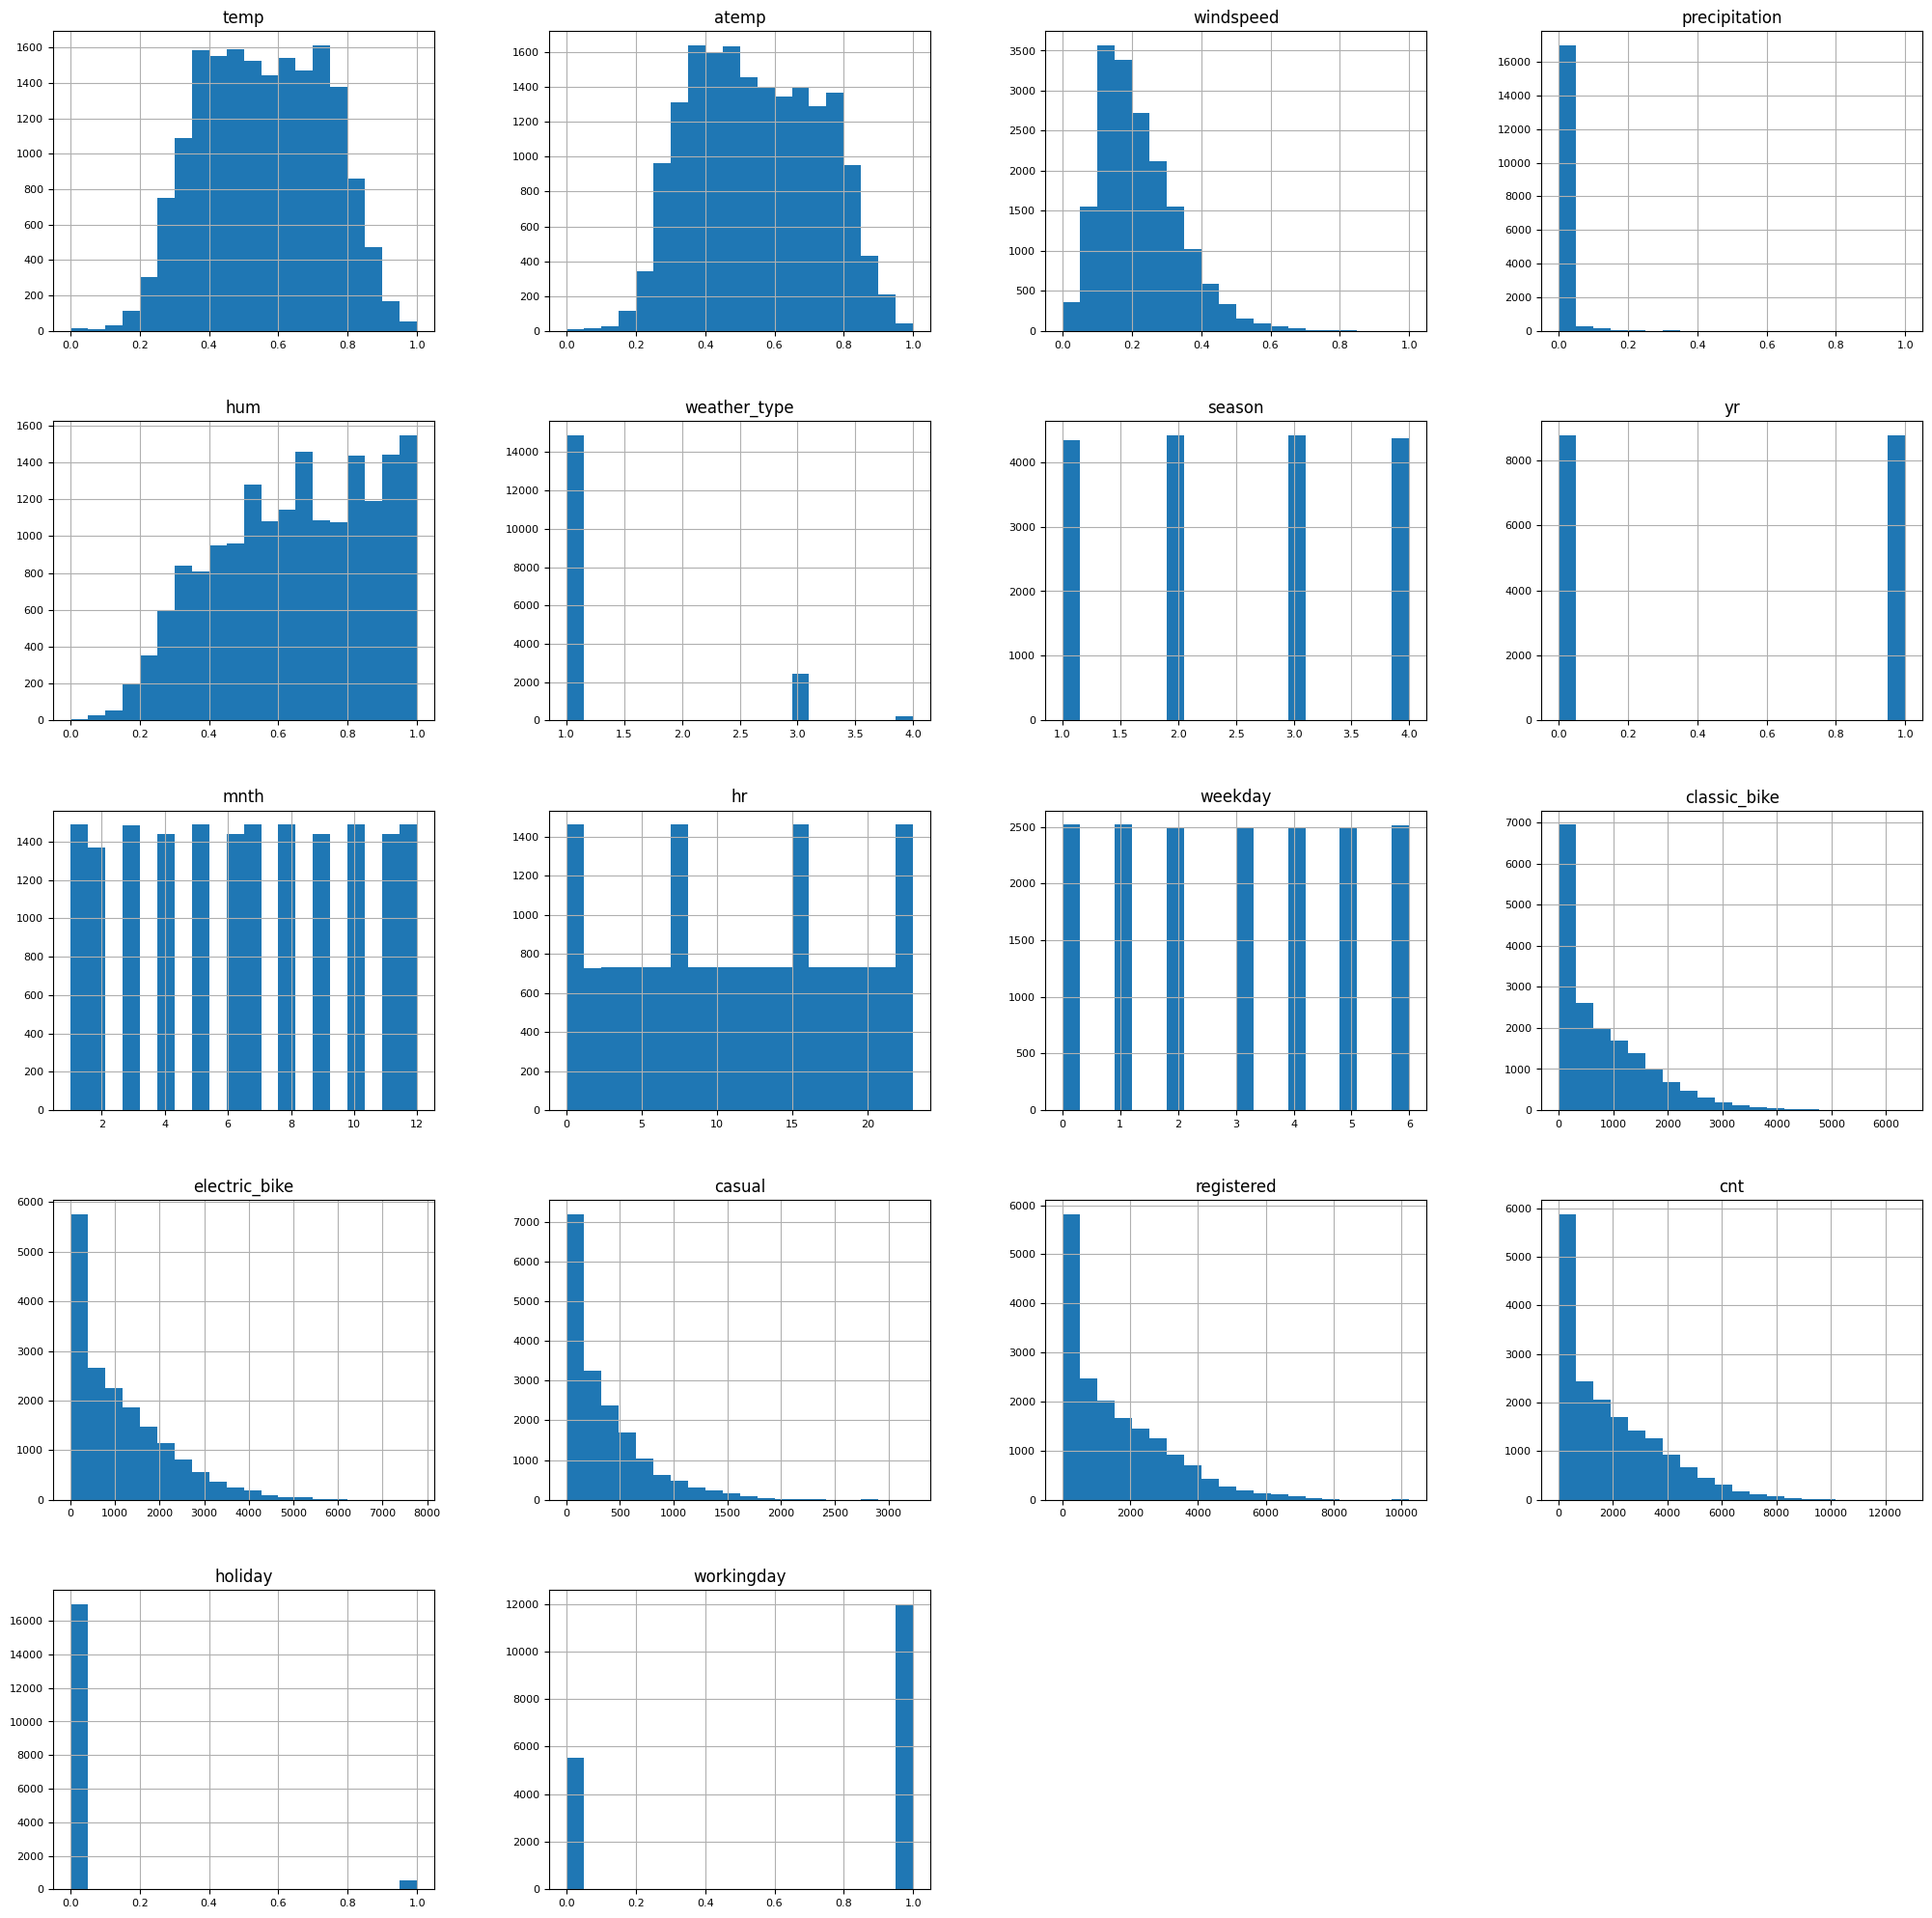

In [17]:
df.hist(figsize=(25, 25), bins=20, xlabelsize=8, ylabelsize=8);

In spite of numeric values, many of the features are in fact categorical (ordinal in some cases).

In [18]:
categorical_columns = ['season', 'yr', 'mnth', 'weekday', 'weather_type', 'holiday', 'workingday']
numerical_columns = [x for x in columns if x not in categorical_columns]
numerical_columns

['temp', 'atemp', 'windspeed', 'precipitation', 'hum', 'hr']

We'll create boxplots for categorical feautres and scatterplots for the remaining features.

In [19]:
sns.set_style("darkgrid")

def snsboxplot(df, x_column, y_column, ax):
  sns.boxplot(
    x = x_column,
    y = y_column,
    data = df,
    ax = ax,
    color = 'blue').set(title=f'Pair distribution of {x_column} and {y_column}');
  #plt.show()


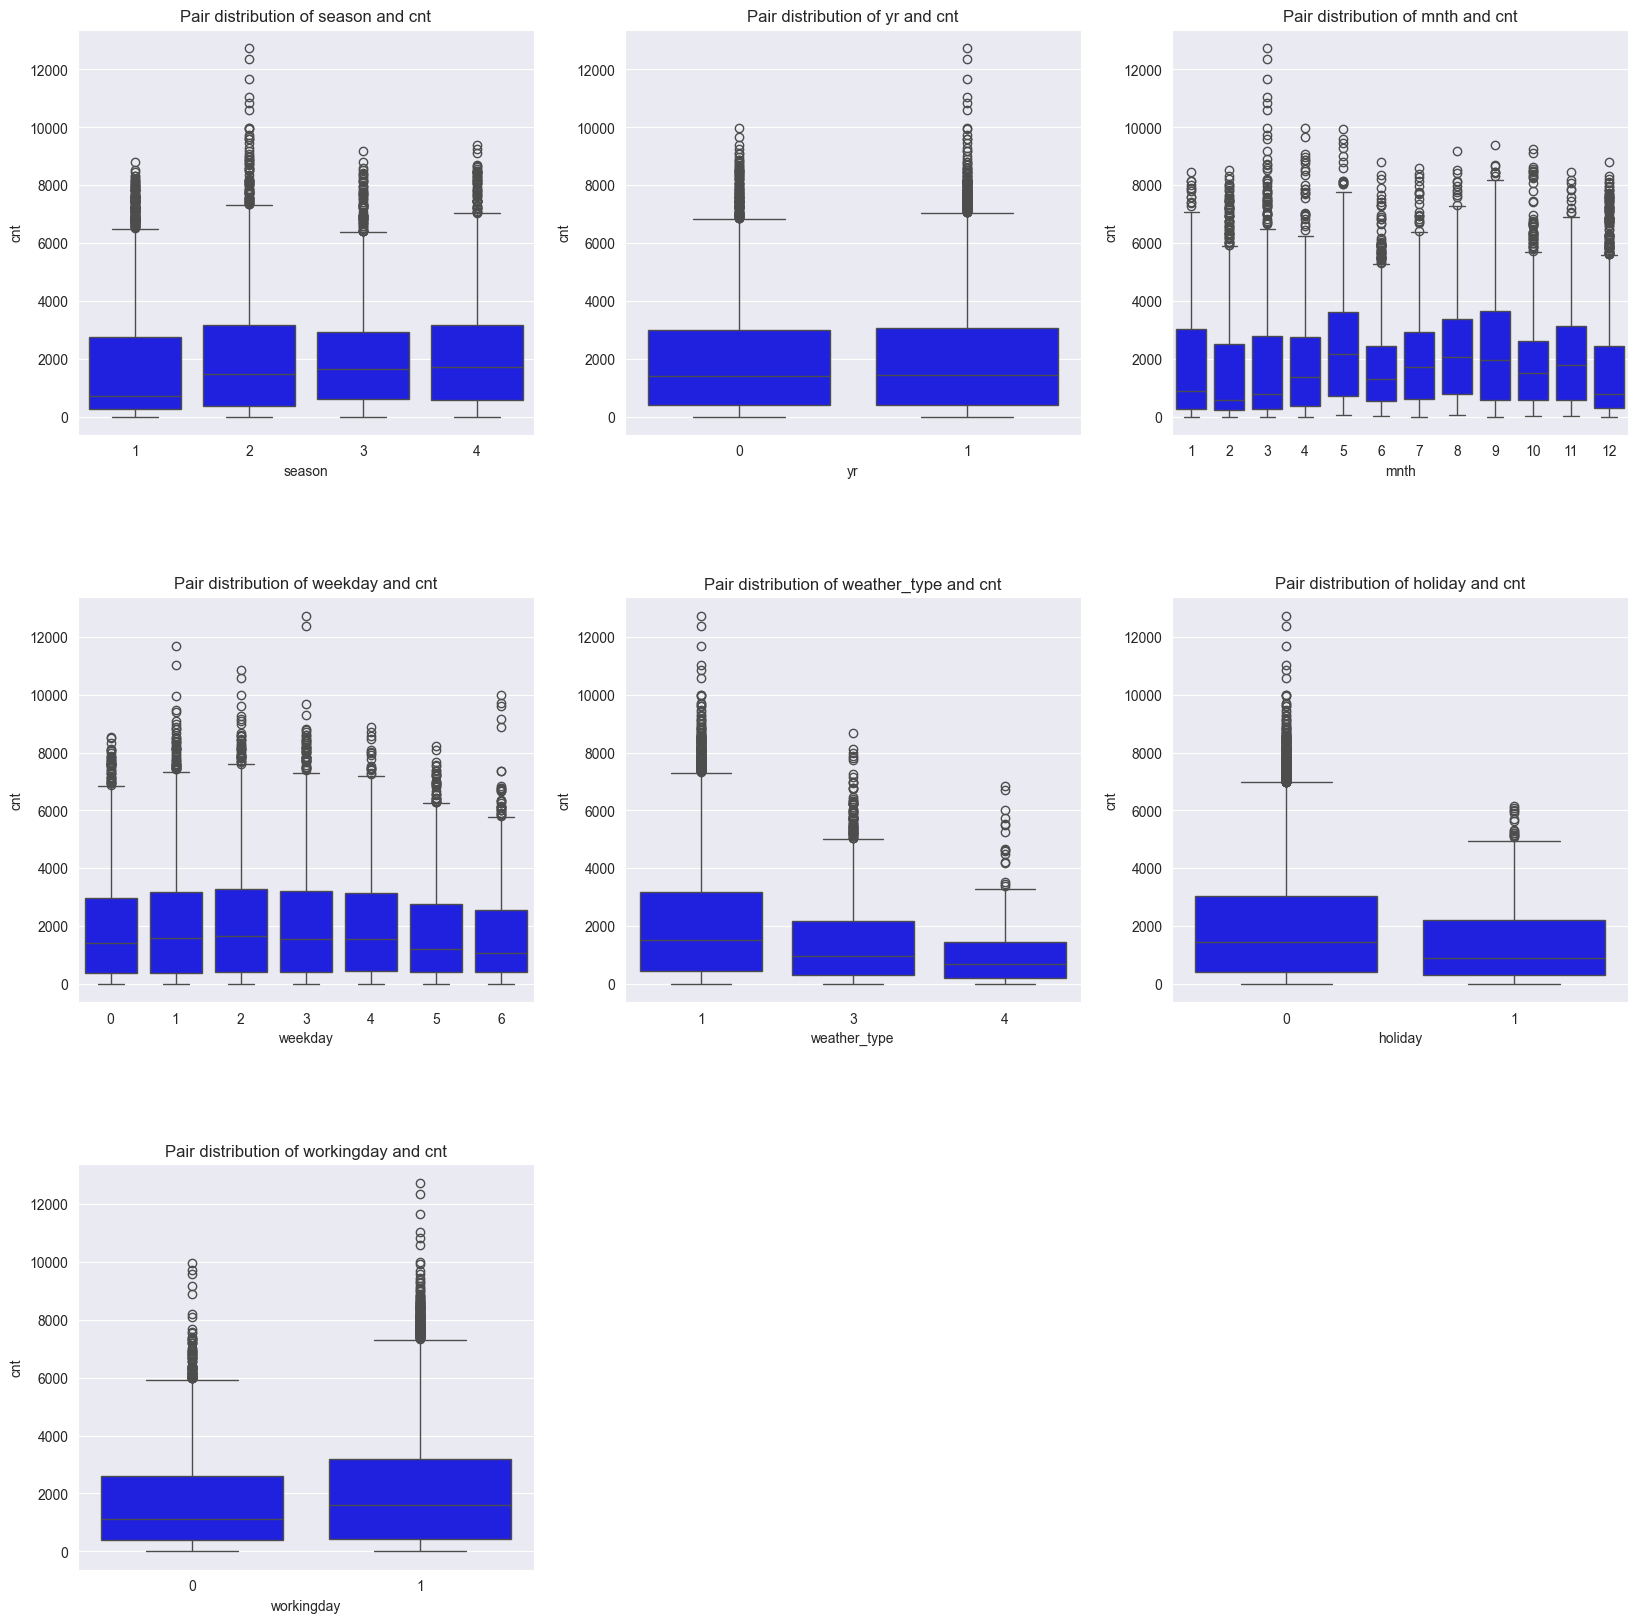

In [20]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
n = len(categorical_columns)

for i, column in enumerate(categorical_columns):
  ax = fig.add_subplot(math.ceil(n/3), 3, i+1)
  snsboxplot(df, column, TARGET, ax)
plt.show()


In [21]:
def sns_scatterplot(df, x_column, y_column, ax):
  sns.scatterplot(
    x = x_column,
    y = y_column,
    data = df,
    ax = ax).set(title=f'Pair distribution of {x_column} and {y_column}');

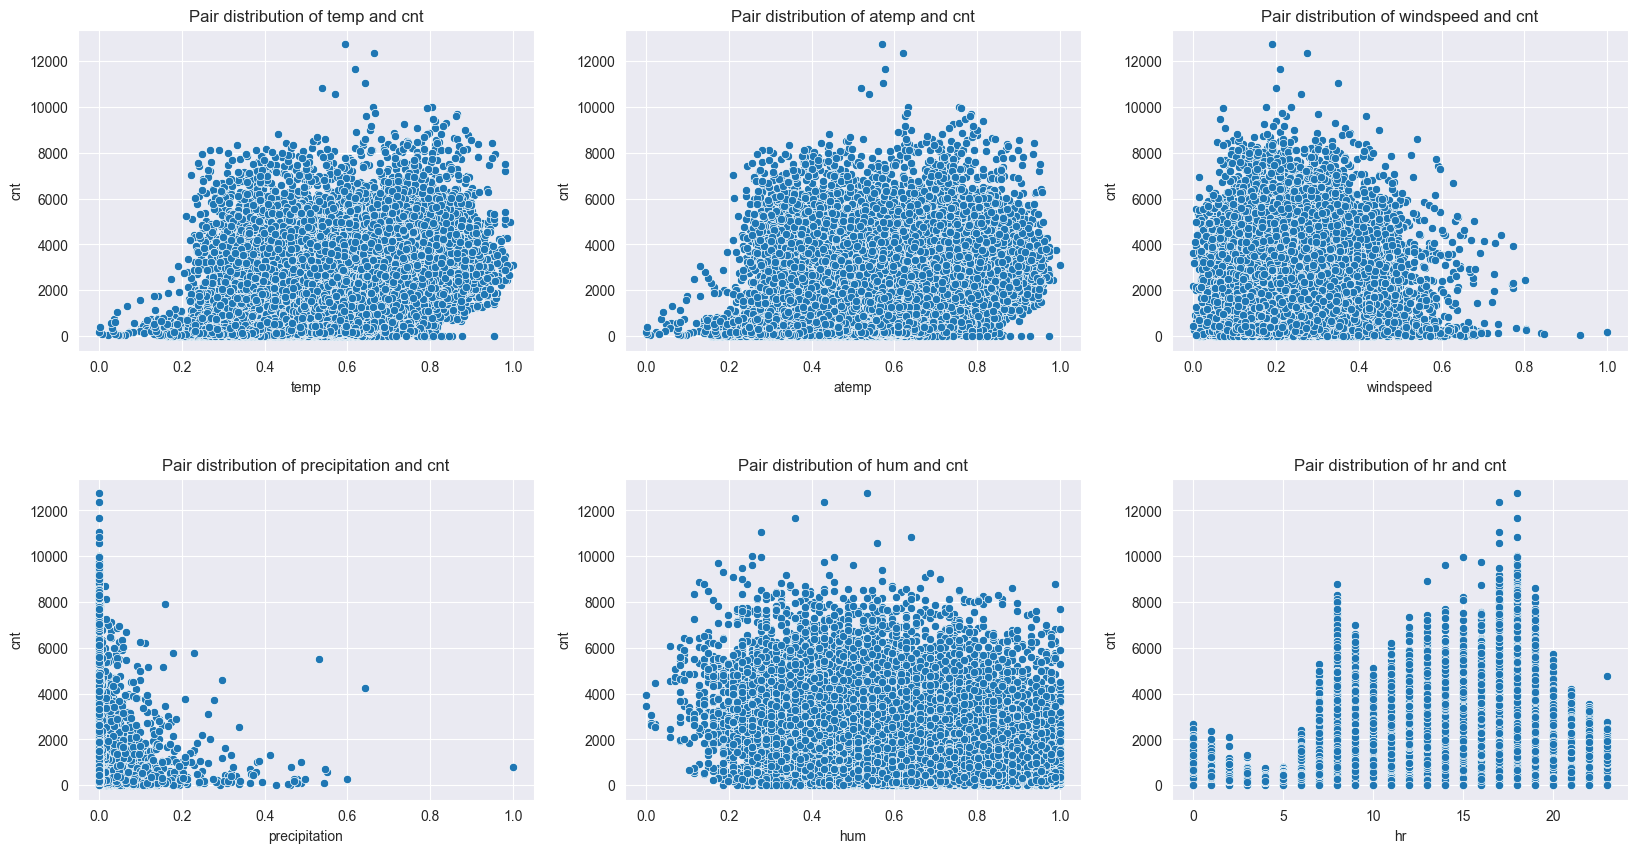

In [22]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
n = len(numerical_columns)

for i, column in enumerate(numerical_columns):
  ax = fig.add_subplot(math.ceil(n/3), 3, i+1)
  sns_scatterplot(df, column, TARGET, ax)
plt.show()


Let's check the correlation matrix of our dataset.

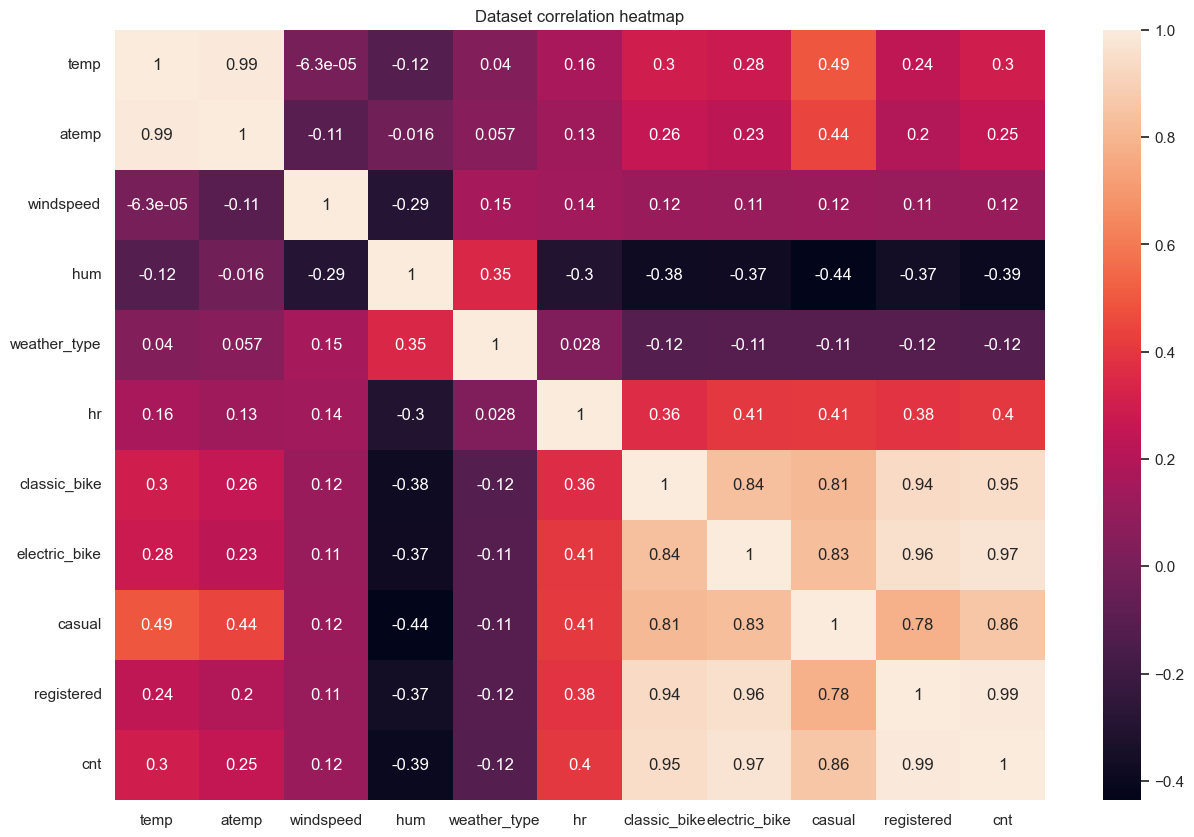

In [23]:
corr = df.corr()
condition = np.abs(corr[TARGET]) > 0.1
top_corr = corr.loc[condition, condition]

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(top_corr, annot=True).set_title("Dataset correlation heatmap");

plt.show()

Obviously the pairs `casual` / `registered` and `classic_bike` / `electric_bike`  are the most correlated with `cnt` because `cnt` is their sum.

Apart from that, some interesting points.

1. Temperature has positive impact on rental count. The higher temperature, the more rentals.
2. Humidity has negative impact on rental count. The higher Humidity (rainy weather), the less rentals.
3. Season has low impact, although we can see from the boxplot above, that there are more rentals in summer and autumn (season=2 and season=3). The hour has more effect on the count. From the scatterplot above we can detect several spikes at hours 8, 17 and 18. Possibly these are the hours when people rent bikes to go to/from work.
4. The temperature and feeling temperature (`temp` and `atemp`) have almost equal impact on the count.

We'll get back to this again while doing feature importance.



#### Useful functions
Some more functions that we'll use later.

In [24]:
def residual_plots(y_pred, y_test):
  errors = y_pred - y_test

  plt.scatter(list(range(len(errors))),errors);
  plt.title("Distibution of errors")
  plt.ylabel('Error');
  plt.xlabel('Index');
  plt.show();

  plt.scatter(y_pred, errors);
  plt.title('Relationship of true value vs error (residual analysis)')
  plt.ylabel('Error');
  plt.xlabel('True value');
  plt.show();

In [25]:
r2_scores = {}
mae_scores = {}
def print_and_save_scores(y_pred, y_test, model_name):
  r2_scores[model_name] = r2_score(y_pred, y_test)
  mae_scores[model_name] = mean_absolute_error(y_pred, y_test)
  print(f'R2 score: {r2_score(y_pred, y_test):.3f}')
  print(f'MAE score: {mean_absolute_error(y_pred, y_test):.3f}')
  print(f'MSE score: {mean_squared_error(y_pred, y_test):.3f}')

## Feature engineering

Let's create several new features to capture time-based patterns (cyclical hours, months, weekdays) and short-term dependencies (lag values), improving the model’s ability to learn periodic and temporal trends.

In [26]:
# Hour of day (24-hour cycle)
df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 24)

# Month of year (12-month cycle)
df['month_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)

# Weekday (7-day cycle)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# Drop originals
df = df.drop(['hr', 'mnth', 'weekday'], axis=1)

# The count of the previous hour
df['lag1'] = df['cnt'].shift(1)
# Deleting the first row with NaN, because it had no previous hour
df = df.dropna(subset=['lag1'])
# Needs to be normalized
df['lag1'] = (df['lag1'] - df['lag1'].min()) / (df['lag1'].max() - df['lag1'].min())

df.head().T


,1,2,3,4,5
temp,0.513258,0.492424,0.513258,5.189394e-01,0.530303
atemp,0.523438,0.478125,0.493750,4.906250e-01,0.498437
windspeed,0.129145,0.277487,0.280977,3.019197e-01,0.289703
precipitation,0.037175,0.000000,0.000000,0.000000e+00,0.000000
hum,0.988372,0.883721,0.813953,6.976744e-01,0.627907
weather_type,4.000000,1.000000,1.000000,1.000000e+00,1.000000
season,1.000000,1.000000,1.000000,1.000000e+00,1.000000
yr,0.000000,0.000000,0.000000,0.000000e+00,0.000000
classic_bike,527.000000,920.000000,1224.000000,1.662000e+03,2052.000000
electric_bike,1026.000000,812.000000,1241.000000,1.617000e+03,1973.000000


In [27]:
columns = df.columns.drop(['casual', 'registered', 'classic_bike', 'electric_bike', TARGET])
columns

Index(['temp', 'atemp', 'windspeed', 'precipitation', 'hum', 'weather_type',
       'season', 'yr', 'holiday', 'workingday', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'lag1'],
      dtype='object')

## Preprocessing
Actually no preprocessing is needed here (apart from deleting some columns that we already did) because there are no missing values and the columns are already scaled. 

Let's divide the dataset into train and test sets, allocating 10% for the test set. I'm setting `shuffle=False` to avoid data leakage.

In [28]:
y = np.log1p(df[TARGET])
y.shape

(17541,)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df[columns], y, random_state=SEED, test_size=0.1, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15786, 17) (1755, 17) (15786,) (1755,)


In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15786 entries, 1 to 15788
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp           15786 non-null  float64
 1   atemp          15786 non-null  float64
 2   windspeed      15786 non-null  float64
 3   precipitation  15786 non-null  float64
 4   hum            15786 non-null  float64
 5   weather_type   15786 non-null  int64  
 6   season         15786 non-null  int32  
 7   yr             15786 non-null  int64  
 8   holiday        15786 non-null  int32  
 9   workingday     15786 non-null  int32  
 10  hour_sin       15786 non-null  float64
 11  hour_cos       15786 non-null  float64
 12  month_sin      15786 non-null  float64
 13  month_cos      15786 non-null  float64
 14  weekday_sin    15786 non-null  float64
 15  weekday_cos    15786 non-null  float64
 16  lag1           15786 non-null  float64
dtypes: float64(12), int32(3), int64(2)
memory usage: 2.0 MB

## Building models

### 1. KNN Regressor

First let's find out the optimal number for k.

In [31]:
%%time
train_r2 = []
train_mae = []

test_r2 = []
test_mae = []
k_max = 15

for k in range(1, k_max):
  knn_model = KNeighborsRegressor(n_neighbors=k, weights='distance')
  knn_model.fit(X_train, y_train)
  train_preds = knn_model.predict(X_train)
  train_r2.append(r2_score(y_train, train_preds));
  train_mae.append(mean_absolute_error(y_train, train_preds))

  knn_predictions = knn_model.predict(X_test)
  test_r2.append(r2_score(y_test, knn_predictions));
  test_mae.append(mean_absolute_error(y_test, knn_predictions))


CPU times: total: 17.3 s
Wall time: 3.38 s


In [32]:
sns.set_theme(rc = {'figure.figsize':(8, 5)})
def train_test_score_change(train_scores, test_scores, score_type):
  plt.plot(range(1, 15), train_scores, color = 'blue', label='Train set')
  plt.plot(range(1, 15), test_scores, color = 'red', label='Test set')
  plt.xlabel('K number')
  plt.ylabel(score_type)
  plt.title(score_type + ' change')
  plt.legend()
  plt.show()

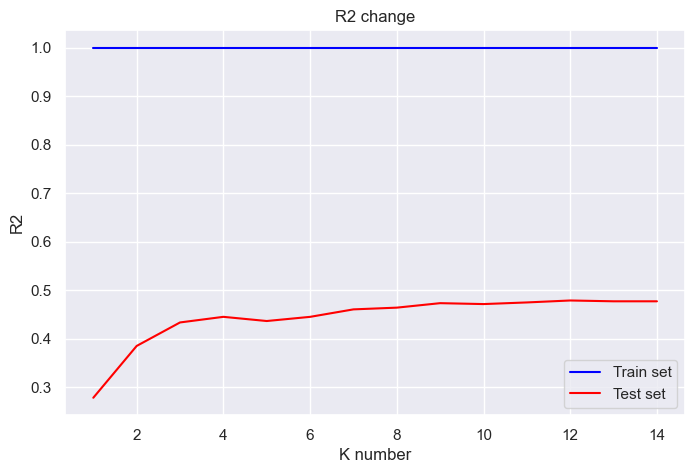

In [33]:
train_test_score_change(train_r2, test_r2, 'R2')

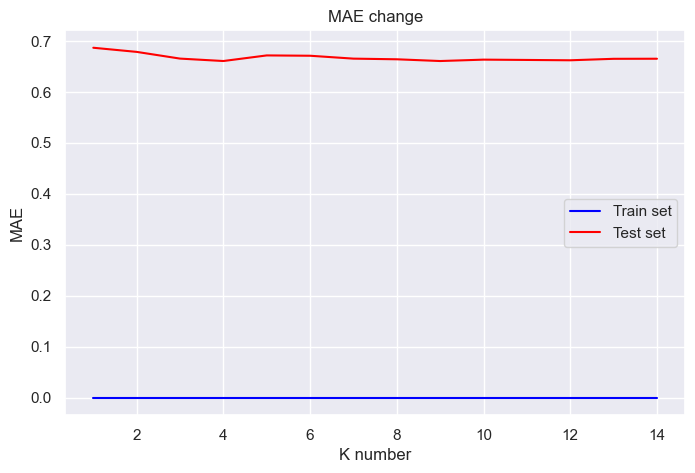

In [34]:
train_test_score_change(train_mae, test_mae, 'MAE')

We can see from the plot that approximately the optimal value is around `k=12`. The scores don't change much after it. Let's check it during Hyperparameters tuning, and then we'll use `hyperopt` library to do that, along with other parameters.

In [35]:
knr = KNeighborsRegressor(n_neighbors=6, weights='distance')
knr.fit(X_train, y_train)
y_pred = knr.predict(X_test)
print(f'R2 score: {r2_score(y_pred, y_test)}')
print(f'MSE score: {mean_squared_error(y_pred, y_test)}')
print(f'MAE score: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE score: {mean_absolute_percentage_error(y_pred, y_test)}')

R2 score: 0.29203786215302185
MSE score: 0.8840841797970963
MAE score: 0.6709867266312508
MAPE score: 0.1027084580679255


The first attempt returned a poor result.

#### Hyperparameters tuning

In [36]:
%%time
def objective(space):
    params = {
        'n_neighbors': space['n_neighbors'],
        'weights': space['weights'],
        'metric' : space['metric'],
    }

    clf = KNeighborsRegressor(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_absolute_error(predictions, y_test)
    print("Mean absolute error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'n_neighbors': scope.int(hp.quniform('n_estimators', 2, k_max, q=1)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'metric': hp.choice('metric', ['minkowski', 'euclidean', 'manhattan']),
    }

knr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Mean absolute error: 0.670, params {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'minkowski'}
Mean absolute error: 0.615, params {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Mean absolute error: 0.669, params {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}
Mean absolute error: 0.662, params {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}
Mean absolute error: 0.612, params {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}
Mean absolute error: 0.676, params {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'minkowski'}
Mean absolute error: 0.592, params {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}
Mean absolute error: 0.581, params {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}
Mean absolute error: 0.662, params {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}
Mean absolute error: 0.669, params {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}

In [37]:
knr_best = space_eval(space, knr_best)
knr_best

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

We see that `hyperopt` returned 11 as the optimal number.

In [38]:
best_knr = KNeighborsRegressor(**knr_best)
best_knr.fit(X_train, y_train)
y_pred_knr = best_knr.predict(X_test)

print_and_save_scores(y_pred_knr, y_test, 'KNeighborsRegressor')

R2 score: 0.342
MAE score: 0.581
MSE score: 0.724


We got fair results on R2 and MAE.

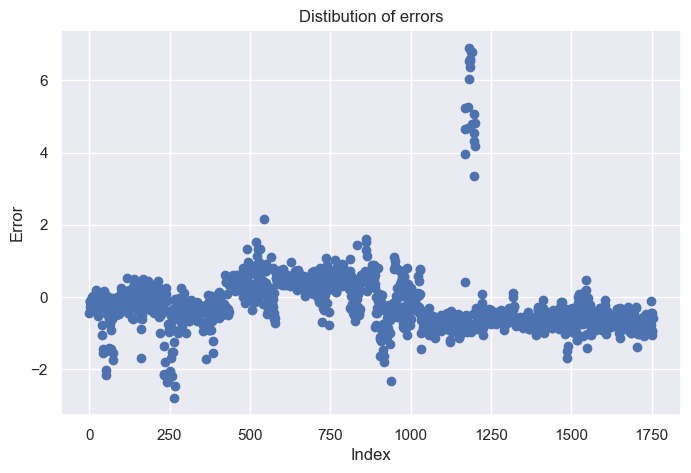

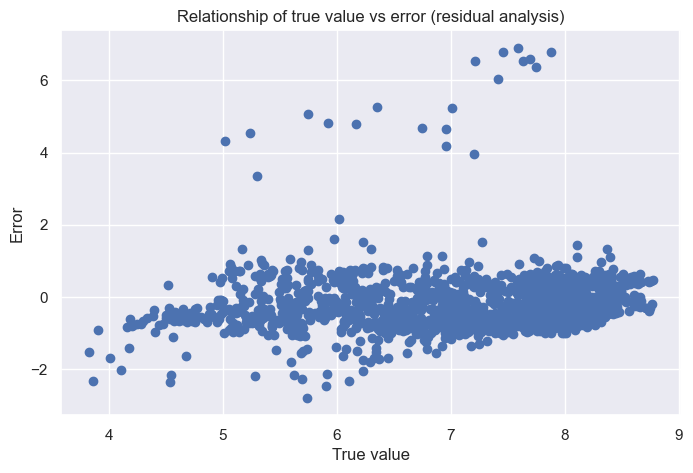

In [39]:
residual_plots(y_pred_knr, y_test)

We see that the error distribution is close to normal, but there is a little heteroskedasticity.

### 2. DecisionTreeRegressor

In [40]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

print_and_save_scores(y_pred_dtr, y_test, 'DecisionTreeRegressor')

R2 score: 0.731
MAE score: 0.218
MSE score: 0.412


Much better result than with KNN, but it can be improved.

#### Hyperparameters tuning

In [41]:
%%time
def objective(space):
    params = {
        'criterion': space['criterion'],
        'splitter': space['splitter'],
        'max_depth': space['max_depth'],
        'min_samples_leaf' : space['min_samples_leaf'],
        'min_samples_split' : space['min_samples_split'],
        'max_leaf_nodes' : space['max_leaf_nodes'],
        'max_features' : space['max_features'],
    }

    clf = DecisionTreeRegressor(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_absolute_error(predictions, y_test)
    print("Mean absolute error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 20, q=1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 10, q=1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, q=1)),
    'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 2, 100, q=1)),
    'max_features': hp.choice('max_features', ["log2", "sqrt", None]),
    }

dtr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Mean absolute error: 0.677, params {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_leaf_nodes': 8, 'max_features': 'sqrt'}
Mean absolute error: 0.897, params {'criterion': 'squared_error', 'splitter': 'random', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 16, 'max_leaf_nodes': 47, 'max_features': 'sqrt'}
Mean absolute error: 0.651, params {'criterion': 'poisson', 'splitter': 'best', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 8, 'max_leaf_nodes': 22, 'max_features': 'sqrt'}
Mean absolute error: 0.350, params {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 6, 'max_leaf_nodes': 24, 'max_features': None}
Mean absolute error: 0.533, params {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 12, 'min_samples_leaf': 9, 'min_samples_split': 9, 'max_leaf_nodes': 94, 'max_features': 'sqrt'}
Mean absolute error: 0.447

In [42]:
dtr_best = space_eval(space, dtr_best)
dtr_best

{'criterion': 'absolute_error',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'splitter': 'best'}

In [43]:
best_dtr = DecisionTreeRegressor(**dtr_best)
best_dtr.fit(X_train, y_train)
y_pred_dtr = best_dtr.predict(X_test)

print_and_save_scores(y_pred_dtr, y_test, 'DecisionTreeRegressor')

R2 score: 0.826
MAE score: 0.211
MSE score: 0.248


The result has improved with the tuning.

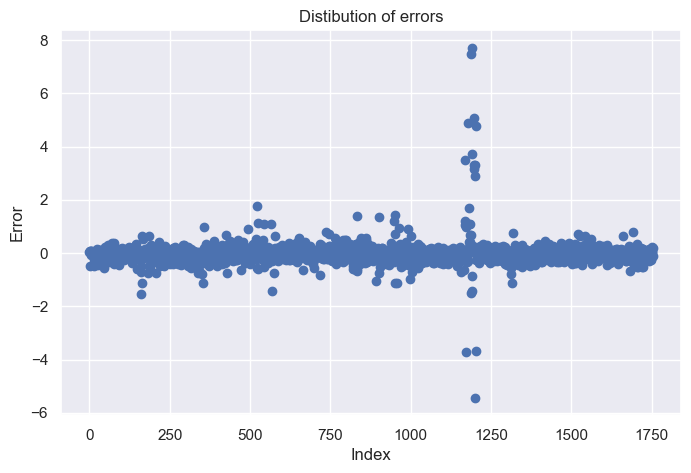

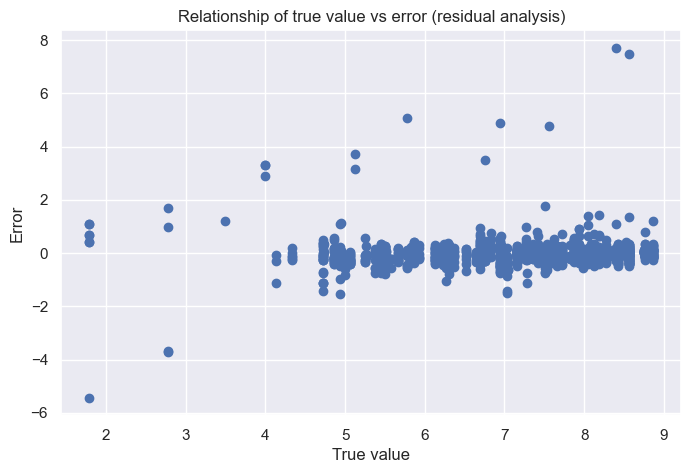

In [44]:
residual_plots(y_pred_dtr, y_test)

Again some heteroskedasticity.

### 3. RandomForestRegressor

In [45]:
rfr = RandomForestRegressor(criterion="squared_error", n_estimators=25, max_depth=20)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

print_and_save_scores(y_pred_rfr, y_test, 'RandomForestRegressor')

R2 score: 0.825
MAE score: 0.175
MSE score: 0.244


The result is as good as the DecisionTree result after the tuning.

#### Hyperparameters tuning

In [ ]:
%%time
def objective(space):
    params = {
        # 'criterion': space['criterion'],
        'max_depth': space['max_depth'],
        'min_samples_leaf' : space['min_samples_leaf'],
        'min_samples_split' : space['min_samples_split'],
        'max_features' : space['max_features'],
        # 'bootstrap' : space['bootstrap'],
        'n_estimators' : space['n_estimators'],
    }

    clf = RandomForestRegressor(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_absolute_error(predictions, y_test)
    print("Mean absolute error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 20, 50, q=10)),
    'max_depth': scope.int(hp.quniform('max_depth', 15, 40, q=5)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, q=1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, q=1)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    # 'bootstrap': hp.choice('bootstrap', [True]),  # fixed for stability
}

rfr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

Mean absolute error: 0.232, params {'max_depth': 25, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 90}
Mean absolute error: 0.239, params {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_features': 'log2', 'bootstrap': True, 'n_estimators': 40}
Mean absolute error: 0.243, params {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'max_features': 'log2', 'bootstrap': True, 'n_estimators': 100}
Mean absolute error: 0.245, params {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 110}
Mean absolute error: 0.230, params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7, 'max_features': 'sqrt', 'bootstrap': True, 'n_estimators': 100}
Mean absolute error: 0.236, params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_features': 'log2', 'bootstrap': True, 'n_estimators': 90}
Mean absolute erro

In [47]:
rfr_best = space_eval(space, rfr_best)
rfr_best

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 50}

In [48]:
%%time
best_rfr = RandomForestRegressor(**rfr_best)
best_rfr.fit(X_train, y_train)
y_pred_rfr = best_rfr.predict(X_test)

print_and_save_scores(y_pred_rfr, y_test, 'RandomForestRegressor')

R2 score: 0.698
MAE score: 0.244
MSE score: 0.336
CPU times: total: 2.11 s
Wall time: 2.12 s


Somehow the result got worse after the tuning. I think more evaluations steps were needed.

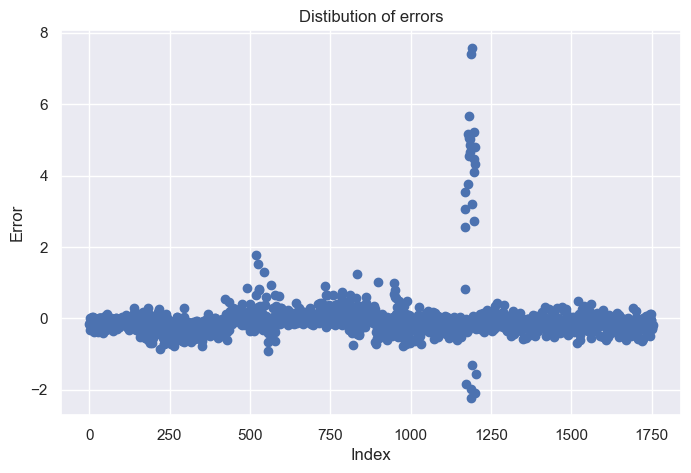

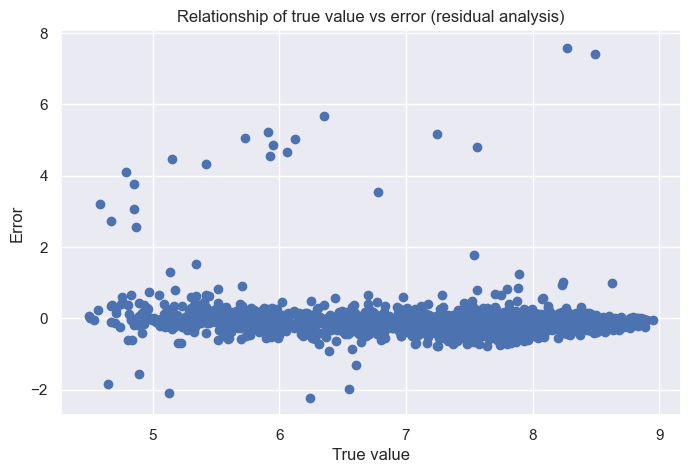

In [49]:
residual_plots(y_pred_rfr, y_test)

Again some heteroskedasticity.

### 4. SVR

In [50]:
%%time
svr = SVR(C=10)
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print_and_save_scores(y_pred_svr, y_test, 'SVR')

R2 score: 0.327
MAE score: 0.890
MSE score: 1.172
CPU times: total: 14.2 s
Wall time: 14.6 s


Not good results before tuning.

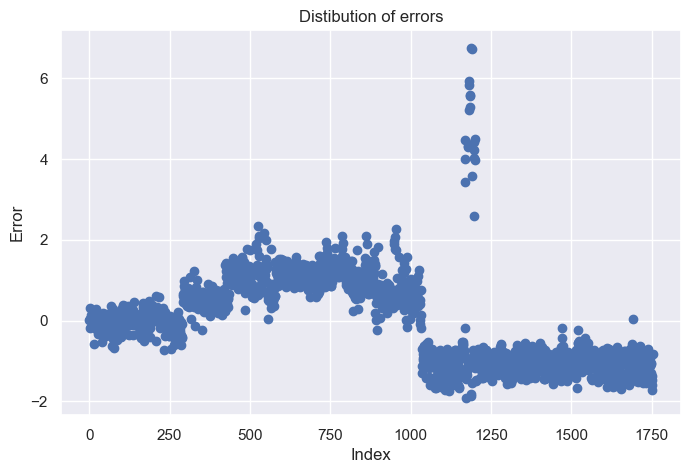

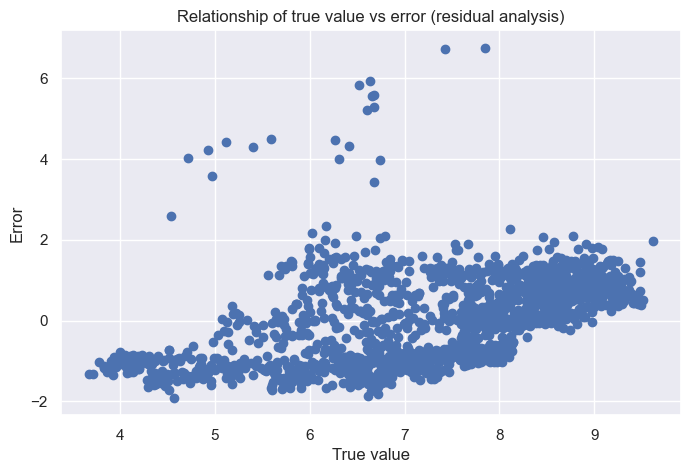

In [51]:
residual_plots(y_pred_svr, y_test)

Again some heteroskedasticity.

#### Hyperparameters tuning


In [52]:
%%time
def objective(space):
    params = {
        'C': space['C'],
        'epsilon': space['epsilon'],
        #'kernel' : space['kernel'],
    }

    clf = SVR(**params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_squared_error(predictions, y_test)
    print("Mean squared error: {:.0f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'C': hp.choice('C', np.logspace(1, 3, 3)), # 1 to 1,000
    'epsilon': hp.choice('epsilon', np.logspace(-3, 1, 5)), # 0.001 to 1
    #'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid']),
    }

svr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5)

Mean squared error: 2, params {'C': 1000.0, 'epsilon': 0.001}
Mean squared error: 1, params {'C': 100.0, 'epsilon': 1.0}                      
Mean squared error: 2, params {'C': 1000.0, 'epsilon': 0.01}                    
Mean squared error: 2, params {'C': 100.0, 'epsilon': 0.01}                     
Mean squared error: 2, params {'C': 1000.0, 'epsilon': 0.001}                   
100%|██████████| 5/5 [43:03<00:00, 516.66s/trial, best loss: 0.7951465870636454]
CPU times: total: 42min 32s
Wall time: 43min 3s


In [53]:
svr_best = space_eval(space, svr_best)
svr_best

{'C': 100.0, 'epsilon': 1.0}

In [54]:
%%time
best_svr = SVR(**svr_best)
best_svr.fit(X_train, y_train)
y_pred_svr = best_svr.predict(X_test)

print_and_save_scores(y_pred_svr, y_test, 'SVR')

R2 score: 0.398
MAE score: 0.662
MSE score: 0.795
CPU times: total: 2.61 s
Wall time: 2.69 s


The results are better, but still poor.

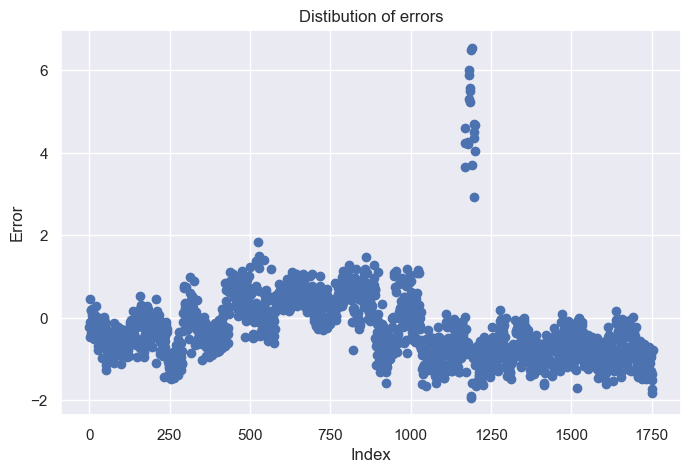

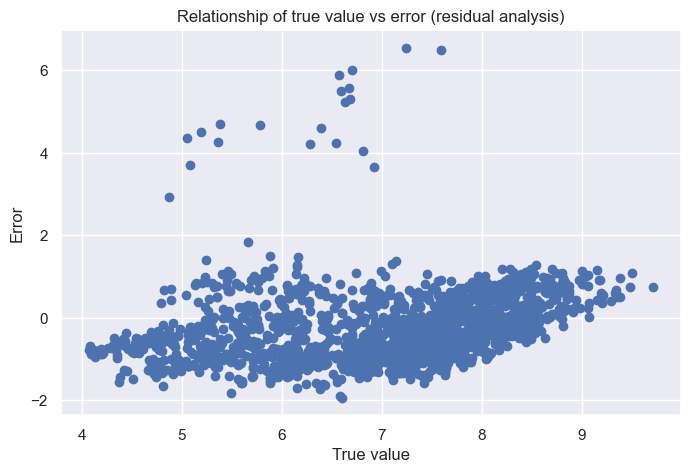

In [55]:
residual_plots(y_pred_svr, y_test)

### 5. AdaBoostRegressor

In [56]:
abr_base_estimator = DecisionTreeRegressor(criterion="squared_error", max_depth=5, min_samples_split=10)
abr = AdaBoostRegressor(estimator=abr_base_estimator, n_estimators=25)
abr.fit(X_train, y_train)
y_pred_abr = abr.predict(X_test)

print_and_save_scores(y_pred_abr, y_test, 'AdaBoostRegressor')

R2 score: 0.531
MAE score: 0.472
MSE score: 0.515


The R2 score is bettern than KNN and SVR, but worse than DecisionTree and RandomForest

#### Hyperparameters tuning

In [57]:
%%time
def objective(space):
    params = {
        'n_estimators': space['n_estimators'],
        'learning_rate': space['learning_rate'],
        'loss' : space['loss'],
    }

    clf = AdaBoostRegressor(random_state = SEED, estimator=abr_base_estimator, **params)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = mean_squared_error(predictions, y_test)
    print("Mean squared error: {:.3f}, params {}".format(score, params))
    return {'loss':score, 'status': STATUS_OK }

space = {
    'n_estimators': scope.int(hp.quniform('min_samples_leaf', 10, 100, q=1)),
    'learning_rate': hp.choice('learning_rate', np.logspace(-3, 2, 7)), # 0.001 to 100
    'loss': hp.choice('loss', ['linear', 'square', 'exponential']),
    }

abrr_best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

Mean squared error: 45.514, params {'n_estimators': 71, 'learning_rate': 14.677992676220706, 'loss': 'square'}
Mean squared error: 0.504, params {'n_estimators': 47, 'learning_rate': 0.31622776601683794, 'loss': 'square'}
Mean squared error: 0.529, params {'n_estimators': 14, 'learning_rate': 2.1544346900318843, 'loss': 'exponential'}
Mean squared error: 0.389, params {'n_estimators': 59, 'learning_rate': 0.046415888336127795, 'loss': 'linear'}
Mean squared error: 42.871, params {'n_estimators': 87, 'learning_rate': 14.677992676220706, 'loss': 'linear'}
Mean squared error: 45.514, params {'n_estimators': 47, 'learning_rate': 100.0, 'loss': 'linear'}
Mean squared error: 0.387, params {'n_estimators': 29, 'learning_rate': 0.046415888336127795, 'loss': 'linear'}
Mean squared error: 0.399, params {'n_estimators': 63, 'learning_rate': 0.046415888336127795, 'loss': 'exponential'}
Mean squared error: 45.514, params {'n_estimators': 20, 'learning_rate': 14.677992676220706, 'loss': 'square'}
Me

In [58]:
abr_best = space_eval(space, abrr_best)
abr_best

{'learning_rate': 0.31622776601683794,
 'loss': 'exponential',
 'n_estimators': 43}

In [59]:
best_abr = AdaBoostRegressor(**abr_best)
best_abr.fit(X_train, y_train)
y_pred_abr = best_abr.predict(X_test)

print_and_save_scores(y_pred_abr, y_test, 'AdaBoostRegressor')

R2 score: 0.018
MAE score: 0.648
MSE score: 0.723


The results got worse.

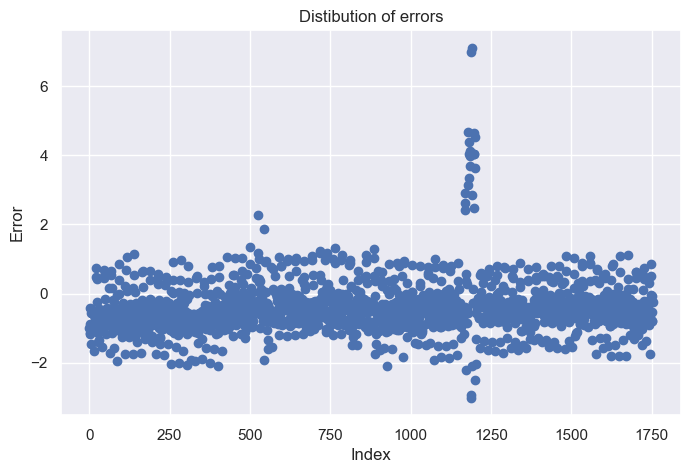

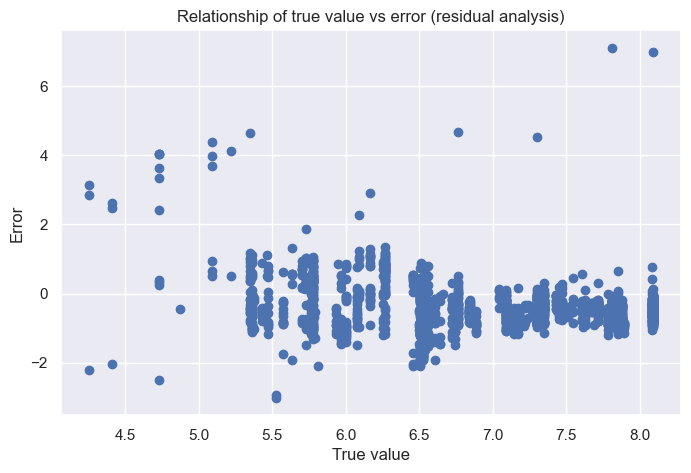

In [60]:
residual_plots(y_pred_abr, y_test)

### Compare scores

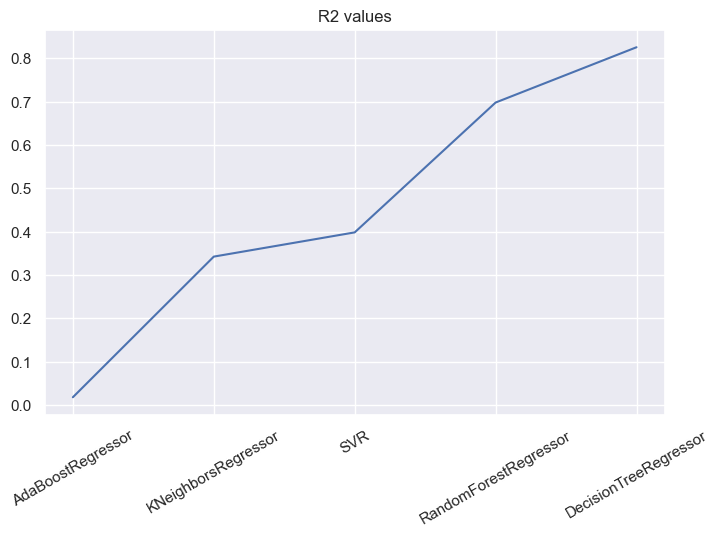

In [61]:
lists = sorted(r2_scores.items(), key=lambda x:x[1]) # sorted by value, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('R2 values')
plt.xticks(rotation=30)
plt.show()

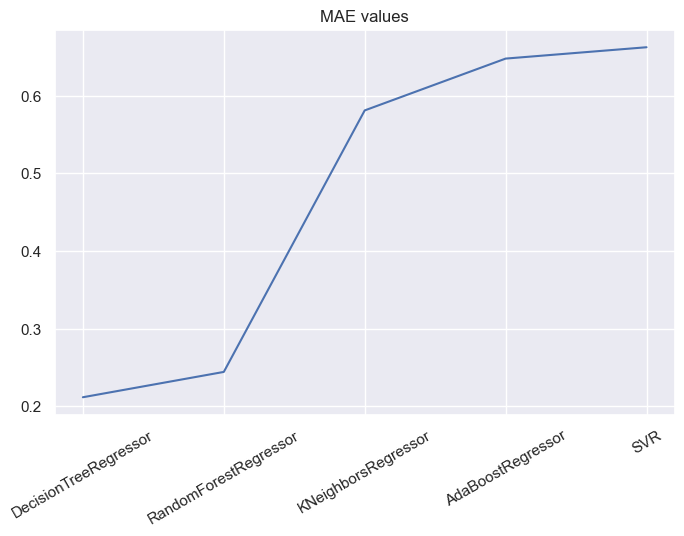

In [62]:
lists = sorted(mae_scores.items(), key=lambda x:x[1]) # sorted by value, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.title('MAE values')
plt.xticks(rotation=30)
plt.show()

DecisionTreeRegressor is the best in both cases - highest R2 and lowest MAE. Let's print its results once again.

In [63]:
print(f'R2 score: {r2_score(y_pred_dtr, y_test)}')
print(f'MAE score: {mean_absolute_error(y_pred_dtr, y_test)}')

R2 score: 0.8257727438594178
MAE score: 0.2114371640602555


### Feature importance

In [64]:
best_dtr.feature_importances_

array([0.00259909, 0.00140562, 0.        , 0.        , 0.        ,
       0.        , 0.00135628, 0.        , 0.        , 0.00852244,
       0.16844964, 0.22537627, 0.        , 0.00262398, 0.01831476,
       0.        , 0.57135193])

In [65]:
#X_train.info()

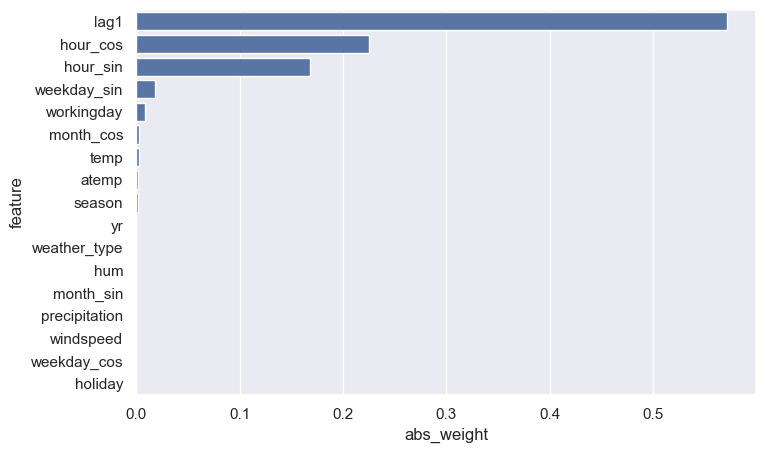

In [66]:
importance = pd.DataFrame({
    'abs_weight': np.abs(best_dtr.feature_importances_),
    'feature': columns
})
importance = importance.sort_values(by='abs_weight', ascending=False)
sns.barplot(y='feature', x='abs_weight', data=importance, orient='h');

* The count of the previous hour (`lag1`) is the most important feauture by far. It's expected because of the time series nature of the data.
* Hour features are the next, which is also expected.
* Next two important features are weekday and workingday. Bike renting counts can be different on working and non-working days.
* Temperature is a bit more important than the feeling temperature.




### Train the best model on the first year, predict the second

In [67]:
X_first = df[df['yr'] == 0]
X_second = df[df['yr'] == 1]
X_first.head()

,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,classic_bike,electric_bike,...,cnt,holiday,workingday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,lag1
1,0.513258,0.523438,0.129145,0.037175,0.988372,4,1,0,527,1026,...,1553,0,0,2.588190e-01,0.965926,0.5,0.866025,-0.781831,0.62349,0.069090
2,0.492424,0.478125,0.277487,0.000000,0.883721,1,1,0,920,812,...,1732,0,0,5.000000e-01,-0.866025,0.5,0.866025,-0.781831,0.62349,0.121850
3,0.513258,0.493750,0.280977,0.000000,0.813953,1,1,0,1224,1241,...,2465,0,0,2.588190e-01,-0.965926,0.5,0.866025,-0.781831,0.62349,0.135903
4,0.518939,0.490625,0.301920,0.000000,0.697674,1,1,0,1662,1617,...,3279,0,0,1.224647e-16,-1.000000,0.5,0.866025,-0.781831,0.62349,0.193452
5,0.530303,0.498437,0.289703,0.000000,0.627907,1,1,0,2052,1973,...,4025,0,0,-2.588190e-01,-0.965926,0.5,0.866025,-0.781831,0.62349,0.257360


In [68]:
X_first.shape, X_second.shape

((8758, 22), (8783, 22))

In [69]:
cnt_first = X_first['cnt']
casual_first = X_first['casual']
registered_first = X_first['registered']
classic_first = X_first['classic_bike']
electric_first = X_first['electric_bike']

cnt_second = X_second['cnt']
casual_second = X_second['casual']
registered_second = X_second['registered']
classic_second = X_second['classic_bike']
electric_second = X_second['electric_bike']


In [70]:
X_first = X_first[columns]
X_second = X_second[columns]

In [71]:
X_first.head()

,temp,atemp,windspeed,precipitation,hum,weather_type,season,yr,holiday,workingday,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,lag1
1,0.513258,0.523438,0.129145,0.037175,0.988372,4,1,0,0,0,2.588190e-01,0.965926,0.5,0.866025,-0.781831,0.62349,0.069090
2,0.492424,0.478125,0.277487,0.000000,0.883721,1,1,0,0,0,5.000000e-01,-0.866025,0.5,0.866025,-0.781831,0.62349,0.121850
3,0.513258,0.493750,0.280977,0.000000,0.813953,1,1,0,0,0,2.588190e-01,-0.965926,0.5,0.866025,-0.781831,0.62349,0.135903
4,0.518939,0.490625,0.301920,0.000000,0.697674,1,1,0,0,0,1.224647e-16,-1.000000,0.5,0.866025,-0.781831,0.62349,0.193452
5,0.530303,0.498437,0.289703,0.000000,0.627907,1,1,0,0,0,-2.588190e-01,-0.965926,0.5,0.866025,-0.781831,0.62349,0.257360


In [72]:
best_dtr_1 = best_dtr
best_dtr_1.fit(X_first, cnt_first)
cnt_second_pred = best_dtr_1.predict(X_second)
print(f'R2 score: {r2_score(cnt_second_pred, cnt_second)}')
print(f'MAE score: {mean_absolute_error(cnt_second_pred, cnt_second)}')
print(f'MSE score: {mean_squared_error(cnt_second_pred, cnt_second)}')

R2 score: 0.9258913081990391
MAE score: 284.81526813161787
MSE score: 238571.37934077193


The R2 score is very high! The errors became larger because the test set became larger.

### Multitarget regression

We're trying to predict `casual` and `registered` columns at once, doing Multitarget regression.

In [73]:
two_column_train = pd.concat([casual_first, registered_first], axis=1)
two_column_test = pd.concat([casual_second, registered_second], axis=1)
print(two_column_train.shape, two_column_test.shape)

(8758, 2) (8783, 2)


In [74]:
best_dtr_2 = best_dtr
best_dtr_2.fit(X_first, two_column_train)
two_column_pred = best_dtr_2.predict(X_second)
print(f'R2 score: {r2_score(two_column_pred, two_column_test)}')
print(f'MAE score: {mean_absolute_error(two_column_pred, two_column_test)}')


R2 score: 0.8581939503398297
MAE score: 172.39707389274736


Again good results when we split the dataset based on year.

Let's sum the predictions for the two columns and make it a prediction for `cnt`.

In [75]:
col_totals = [ sum(x) for x in zip(*two_column_pred) ]
col_totals

[3062488.0, 13815264.0]

In [76]:
one_column_pred = two_column_pred[:,0] + two_column_pred[:,1]

In [77]:
print(f'R2 score: {r2_score(one_column_pred, cnt_second)}')
print(f'MAE score: {mean_absolute_error(one_column_pred, cnt_second)}')

R2 score: 0.9160605282038417
MAE score: 298.87714903791414


Good results again.

### Conclusion
Overall the results are good on tree based models and bad on KNN and SVR. The highest R2 was 0.826.

The results became better when I splitted the dataset into 2 equal parts based on the year, achieving R2 score 0.926.
